# Onset asynchrony

## Import dependencies, set constants etc.

In [1]:
from itertools import pairwise, combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from joblib import Parallel, delayed

import src.visualise.visualise_utils as vutils
from src import utils
from src.features.rhythm_features import ProportionalAsynchrony, get_beats_from_matched_onsets
from src.visualise.asynchrony_plots import *

## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.load_corpus_from_files(fr'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')

## Get position of marked beats
Now we can iterate through successive downbeats in a performance and express the position of each marked beat proportionally.

In [3]:
def process_track(track):
    asyncs = []
    # Get information from our OnsetMaker instance
    bandleader = track.item['bandleader']
    tempo = track.tempo
    temp = pd.DataFrame(track.summary_dict)
    # Obtain beats from matched onsets
    temp['beats_perf'] = get_beats_from_matched_onsets(track.summary_dict)
    idx = temp[temp['metre_auto'] == 1].index
    # Iterate through successive downbeats
    for downbeat1, downbeat2 in pairwise(idx):
        # Get all the beats marked between our two downbeats (beat 1 bar 1, beat 1 bar 2)
        bw = temp[(downbeat1 <= temp.index) & (temp.index < downbeat2)]
        sub = bw[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
        # Get the first downbeat of the first bar, and the last downbeat of the second
        first, last = temp[temp.index == downbeat1]['beats_perf'].iloc[0], temp[temp.index == downbeat2]['beats_perf'].iloc[0]
        # Scale our onsets to be proportional with our first and last values
        prop = (sub - first) / (last - first)
        # Drop values after 1/16th note or before 1/32nd note, the size of the window we use
        upper_bound = (((bw['metre_auto'] - 1) * 1/4) + 1/16)
        lower_bound = ((bw['metre_auto'] - 1) * 1/4) - 1/32
        for col in prop.columns:
            prop[col][(prop[col] < lower_bound) | (prop[col] > upper_bound)] = np.nan
        # Convert values to degrees
        prop *= 360
        prop = pd.concat([prop, bw['metre_auto']], axis=1)
        # Iterate through each column and add values to our list
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            for _, val in prop[[instr, 'metre_auto']].dropna().iterrows():
                asyncs.append(dict(instr=instr, asynchrony=val[instr], beat=val['metre_auto'], bandleader=bandleader, tempo=tempo))
    return asyncs

In [4]:
with Parallel(n_jobs=-1, verbose=10) as par:
    asynchronies = par(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

In [5]:
df = pd.DataFrame([x for xs in asynchronies for x in xs])

In [6]:
print(df[df['instr'] == 'piano'].shape)

(282576, 5)


## Clean dataset

In [7]:
# First, we sort the dataset so that instruments are in the order piano-bass-drums -- this is for hue mapping
df = (
    df.set_index('instr')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

In [8]:
# Offset the asynchrony column so that drums average beat 1 is shifted to 0
df['asynchrony_offset'] = df['asynchrony'] - df[(df['instr'] == 'drums') & (df['beat'] == 1)]['asynchrony'].mean()
# Adjust the asynchrony values so that asynchrony is independent of beat location
df['asynchrony_adjusted'] = (df['asynchrony'] / 360) - ((df['beat'] - 1) * 1/4)
# Adjust the offset beat values
df['asynchrony_adjusted_offset'] = (df['asynchrony_offset'] / 360) - ((df['beat'] - 1) * 1/4)

## Create circular plot of asynchrony by beat number

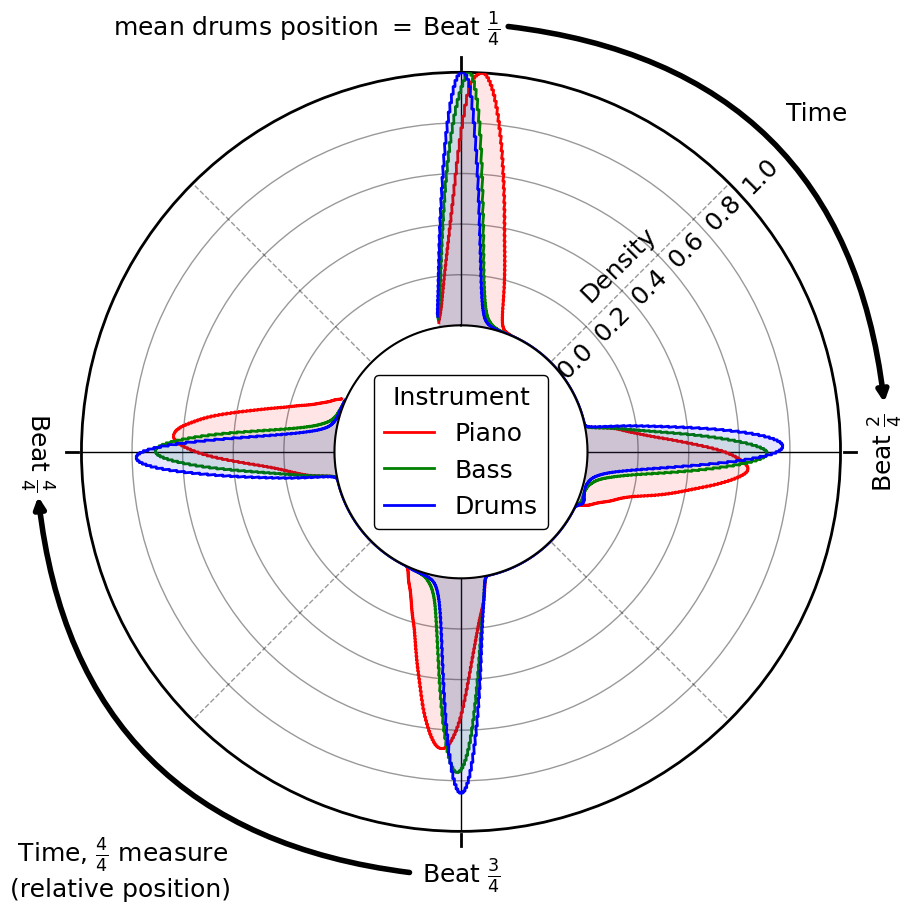

In [9]:
PolarPlotAsynchrony(df).create_plot()
plt.show()

## Bootstrap differences per instrument

In [10]:
grouped = df.groupby(['bandleader', 'instr', 'beat']).mean().reset_index(drop=False)
bls = pd.Series(grouped['bandleader'].unique())

def get_boot(rs):
    boot_bls = bls.sample(frac=1, random_state=rs, replace=True).values 
    return pd.concat([grouped[grouped['bandleader'] == bl] for bl in boot_bls]).reset_index(drop=True)

with Parallel(n_jobs=-1, verbose=1) as par:
    boots = par(delayed(get_boot)(s) for s in range(vutils.N_BOOT))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4864 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   10.5s finished


In [11]:
def proc_boot(bt, ins1, ins2):
    val1 = bt[bt['instr'] == ins1]['asynchrony_adjusted_offset']
    val2 = bt[bt['instr'] == ins2]['asynchrony_adjusted_offset']
    return val1.mean() - val2.mean()

all_res = []
for i1, i2 in combinations(grouped['instr'].unique(), 2):
    true_val1 = grouped[grouped['instr'] == i1]['asynchrony_adjusted_offset']
    true_val2 = grouped[grouped['instr'] == i2]['asynchrony_adjusted_offset']
    true_mean = true_val1.mean() - true_val2.mean()
    with Parallel(n_jobs=-1, verbose=1) as par:
        iteration_res = par(delayed(proc_boot)(b, i1, i2) for b in boots)
    all_res.append(dict(instr1=i1, instr2=i2, low=np.percentile(iteration_res, 2.5), mean=true_mean, high=np.percentile(iteration_res, 97.5)))
boot_df = pd.DataFrame(all_res).set_index(['instr1', 'instr2'])
# Multiply by four to express as a beat (not a bar of 4 beats)
(boot_df * 100 * 4).round(1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 9100 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 8978 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 8978 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 

low  mean  high
instr1 instr2                 
bass   drums   1.0   1.5   2.0
       piano  -4.9  -4.0  -3.2
drums  piano  -6.3  -5.6  -4.8

## Model differences in piano 'lateness' vs tempo

In [14]:
tempo_res = []
for idx, grp in df.groupby(['bandleader', 'tempo']):
    if len(grp.dropna()) < 15:
        continue

    piano = grp[grp['instr'] == 'piano']['asynchrony_adjusted_offset'].mean()
    for instr in ['bass', 'drums']:
        other = grp[grp['instr'] == instr]['asynchrony_adjusted_offset'].mean()
        other_diff = piano - other
        tempo_res.append(dict(bandleader=idx[0], tempo=idx[1], instr=instr, diff=other_diff))
tempo_df = pd.DataFrame(tempo_res).dropna()
tempo_df['tempo_standard'] = (tempo_df['tempo'] - tempo_df['tempo'].mean()) / tempo_df['tempo'].std()

In [15]:
md = smf.mixedlm(
    "diff ~ tempo_standard * C(instr, Treatment(reference='bass'))",
    data=tempo_df,
    groups=tempo_df['bandleader'],
    re_formula="0 + tempo_standard + C(instr, Treatment(reference='bass'))"
).fit()
print(md.summary())
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.to_numpy().mean())
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                            Dependent Variable:                            diff     
No. Observations:                             2586                               Method:                                        REML     
No. Groups:                                   29                                 Scale:                                         0.0000   
Min. group size:                              10                                 Log-Likelihood:                                9082.6439
Max. group size:                              506                                Converged:                                     Yes      
Mean group size:                              89.2                                                                                       
------------------------------------------------------------------------------------

In [16]:
md.params * 400

Intercept                                                                                           3.993655
C(instr, Treatment(reference='bass'))[T.drums]                                                      1.415039
tempo_standard                                                                                     -0.424411
tempo_standard:C(instr, Treatment(reference='bass'))[T.drums]                                       0.304355
C(instr, Treatment(reference='bass'))[bass] Var                                                   296.028158
C(instr, Treatment(reference='bass'))[bass] x C(instr, Treatment(reference='bass'))[drums] Cov    235.177577
C(instr, Treatment(reference='bass'))[drums] Var                                                  239.607040
C(instr, Treatment(reference='bass'))[bass] x tempo_standard Cov                                   50.213959
C(instr, Treatment(reference='bass'))[drums] x tempo_standard Cov                                  35.923345
tempo_standard Var 

In [17]:
md.conf_int() * 400

,0,1
Intercept,3.105248,4.882063
"C(instr, Treatment(reference='bass'))[T.drums]",0.924669,1.905409
tempo_standard,-0.749353,-0.099468
"tempo_standard:C(instr, Treatment(reference='bass'))[T.drums]",0.085681,0.523028
"C(instr, Treatment(reference='bass'))[bass] Var",126.615490,465.440825
"C(instr, Treatment(reference='bass'))[bass] x C(instr, Treatment(reference='bass'))[drums] Cov",95.444405,374.910749
"C(instr, Treatment(reference='bass'))[drums] Var",102.614011,376.600069
"C(instr, Treatment(reference='bass'))[bass] x tempo_standard Cov",3.442775,96.985144
"C(instr, Treatment(reference='bass'))[drums] x tempo_standard Cov",-4.036395,75.883085
tempo_standard Var,8.870030,49.220632


## Drums autocorrelation weak v strong beats

In [ ]:
weak_iois = []
strong_iois = []
# Iterate over every track
for num, track in enumerate(onsets[:1], 1):
    print(f'{num} / {len(onsets)}')
    if track.item['time_signature'] == 3:
        continue
    temp = pd.DataFrame(track.summary_dict)[['drums', 'metre_manual']]
    temp['ioi'] = temp['drums'].diff()
    print(temp)

## Get piano - drums/bass asynchronies

In [ ]:
asynchronies = []
# Iterate over every track
for num, track in enumerate(onsets, 1):
    print(f'{num} / {len(onsets)}')
    # if track.item['time_signature'] == 3:
    #     continue
    summary_df = pd.DataFrame(track.summary_dict)
    asy = ProportionalAsynchrony(summary_df=summary_df, my_instr_name='piano').asynchronies
    piano = asy[asy['instr'] == 'piano'].reset_index(drop=True)['asynchrony_adjusted']
    bass = asy[asy['instr'] == 'bass'].reset_index(drop=True)['asynchrony_adjusted']
    drums = asy[asy['instr'] == 'drums'].reset_index(drop=True)['asynchrony_adjusted']
    bass_asy = (piano - bass).dropna().values
    drums_asy = (piano - drums).dropna().values
    bass_drums_asy = (bass - drums).dropna().values
    for instr, asyncs in zip(['bass', 'drums', 'bass_drums'], [bass_asy, drums_asy, bass_drums_asy]):
        for async_ in asyncs:
            asynchronies.append(dict(instr=instr, bandleader=track.item['pianist'], asynchrony=async_))

In [ ]:
asy_df = pd.DataFrame(asynchronies)

In [ ]:
asy_df.groupby('instr').mean() * 100 * 4

In [ ]:
jm = asy_df[(asy_df['instr'] == 'bass') & (asy_df['bandleader'] == 'Bud Powell')]['asynchrony']
means = [jm.sample(frac=1, replace=True, random_state=i).mean() for i in range(10000)]
print(np.quantile(means, 0.025), np.quantile(means, 0.975))

In [ ]:
HistPlotProportionalAsynchronyTriosPiano(asy_df, include_images=True).create_plot()
plt.show()

In [ ]:
from joblib import Parallel, delayed

def process(state_, instr_):
    bls_ = pd.Series(asy_df['bandleader'].unique()).sample(frac=1, replace=True, random_state=state_)
    means_ = pd.concat(asy_df[(asy_df['bandleader'] == bl) & (asy_df['instr'] == instr_)]['asynchrony'] for bl in bls_).mean()
    return means_

for instr in ['bass_drums']:
    means = Parallel(n_jobs=-1, verbose=10)(delayed(process)(state, instr) for state in range(vutils.N_BOOT))
    print(instr, asy_df[asy_df['instr'] == instr]['asynchrony'].mean(), np.percentile(means, 2.5), np.percentile(means, 97.5))